In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyeit import mesh
import os
from glob import glob

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from vae_model import vae_model
from sklearn.model_selection import train_test_split
from src.util import plot_mesh_permarray


2024-11-29 12:21:04.267489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732882864.280856  370965 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732882864.285026  370965 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 12:21:04.300875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1732882871.125217  370965 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

In [2]:
n_el = 16  # nb of electrodes
use_customize_shape = False
if use_customize_shape:
    # Mesh shape is specified with fd parameter in the instantiation, e.g : fd=thorax
    mesh_obj = mesh.create(n_el, h0=0.05, fd=thorax)
else:
    mesh_obj = mesh.create(n_el, h0=0.05)
el_pos = mesh_obj.el_pos                    # Elektrodenpositionen extrahieren

# Extrahiert Informationen über das Maschennetz wie Elektrodenpositionen, Knoten und Elemente

pts = mesh_obj.node                         # Knoten extrahieren
tri = mesh_obj.element                      # Elemente extrahieren
x, y = pts[:, 0], pts[:, 1]                 # x- und y-Koordinaten trennen

In [3]:
def loadData():
    file_list = [] 

    data_dirs = glob("data*/")

    for directory in data_dirs:
        file_list = glob(f"{directory}*.npz")  
        file_list = sorted(file_list) 
        gamma = list()
        
        for file in file_list:
            tmp = np.load(file, allow_pickle=True)
            gamma.append(tmp["gamma"])

    return gamma

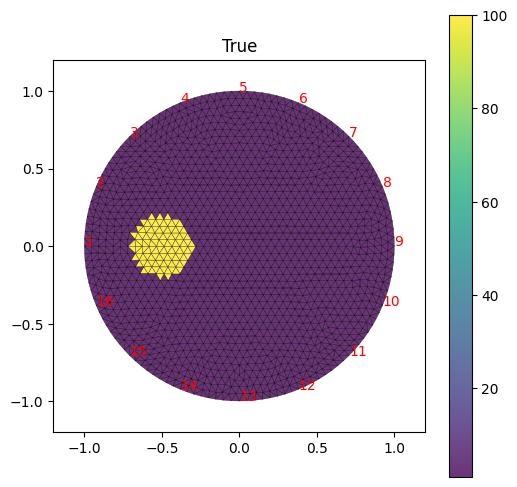

In [4]:
gamma = loadData()
gamma = np.array(gamma)
gamma = np.expand_dims(gamma, axis=2)
gamma.shape


plot_mesh_permarray(mesh_obj, gamma[500,:,0], title="True")

In [5]:
vae = vae_model()
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [6]:
vae.encoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 2821, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_1    │ (None, 3181, 1)   │          0 │ input_layer_2[0]… │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 3181, 8)   │         80 │ zero_padding1d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3181, 8)   │         32 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 3181, 8)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 1591, 8)   │        584 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1591, 8)   │         32 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 1591, 8)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 1591, 16)  │      1,168 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1591, 16)  │         64 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 1591, 16)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 796, 16)   │      2,320 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 796, 16)   │         64 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 796, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 796, 32)   │      4,640 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 796, 32)   │        128 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 796, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 398, 32)   │      9,248 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 398, 32)   │        128 │ conv1d_17[0][0] 

 Total params: 156,360 (610.78 KB)

 Trainable params: 155,880 (608.91 KB)

 Non-trainable params: 480 (1.88 KB)

In [7]:
vae.decoder.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1280)           │        11,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 80, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 400, 64)        │         9,280 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 400, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 400, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 400, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_6              │ (None, 800, 32)        │        18,464 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 800, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 800, 32)        │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 800, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_7              │ (None, 1600, 16)       │         4,624 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 1600, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 1600, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 95,161 (371.72 KB)

 Trainable params: 94,681 (369.85 KB)

 Non-trainable params: 480 (1.88 KB)

In [8]:
gamma_train, gamma_test = train_test_split(gamma, test_size=0.2, random_state=42)

In [9]:
gamma_train.shape, gamma_test.shape

((800, 2821, 1), (200, 2821, 1))

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - kl_loss: 15942.7236 - loss: 1087590.6250 - reconstruction_loss: 1071647.8750 - val_kl_loss: 49.3260 - val_loss: 1001191.0000 - val_reconstruction_loss: 1001141.5625
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - kl_loss: 61.3352 - loss: 954198.1250 - reconstruction_loss: 954136.7500 - val_kl_loss: 74.3180 - val_loss: 773265.5625 - val_reconstruction_loss: 773191.3125
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - kl_loss: 89.7889 - loss: 717583.5000 - reconstruction_loss: 717493.7500 - val_kl_loss: 133.7064 - val_loss: 623338.0625 - val_reconstruction_loss: 623204.3125
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - kl_loss: 149.9767 - loss: 599821.7500 - reconstruction_loss: 599671.8125 - val_kl_loss: 193.0058 - val_loss: 534409.5000 - val_reconstruction_loss: 534216.4375
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - kl_loss: 201.1541 - loss: 526370.4375 - reconstruction_loss: 526169.3125 - val_kl_loss: 232.8

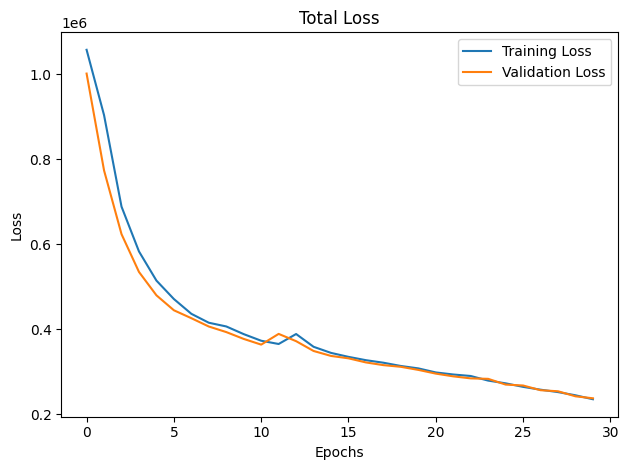

In [10]:
history_vae = vae.fit(gamma_train, epochs=30, batch_size=32, validation_split=0.1)

plt.plot(history_vae.history["loss"], label="Training Loss")
plt.plot(history_vae.history["val_loss"], label="Validation Loss")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
z_mean, z_log_var, z = vae.encoder.predict(gamma_test)
gamma_hat = vae.decoder.predict(z) 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


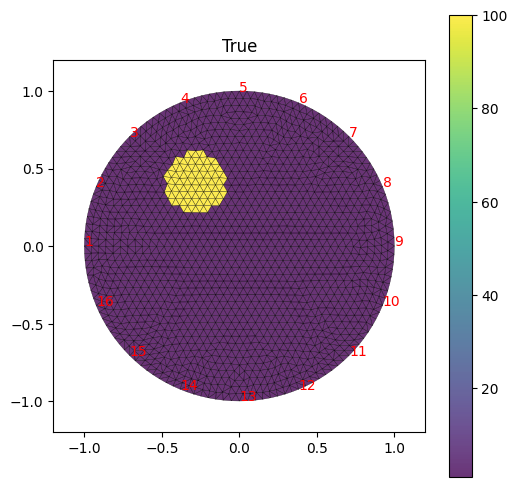

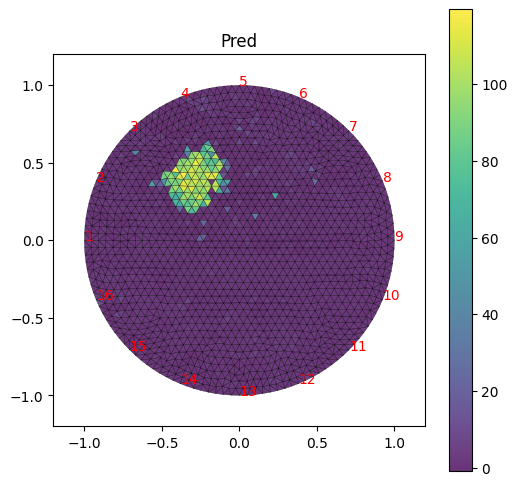

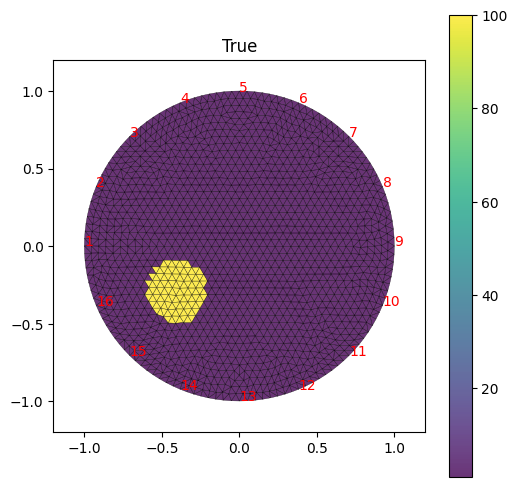

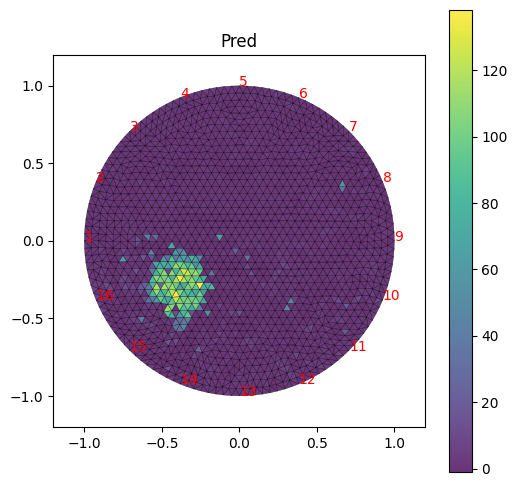

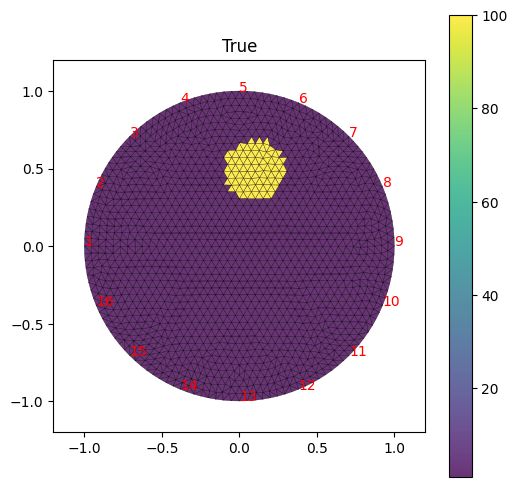

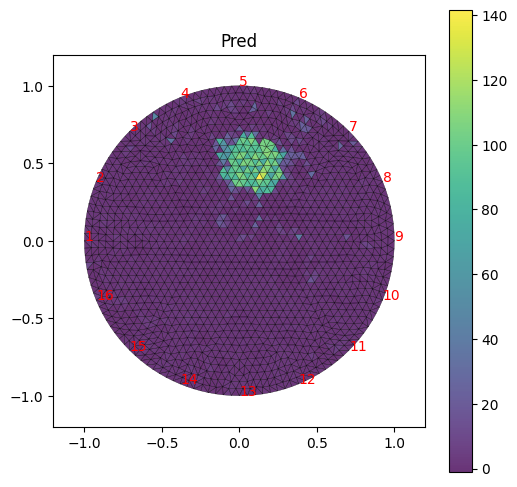

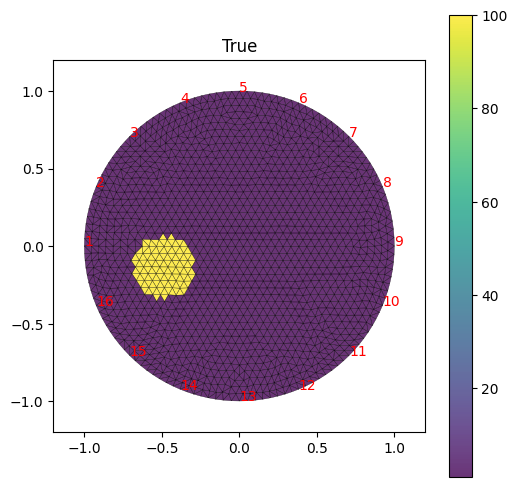

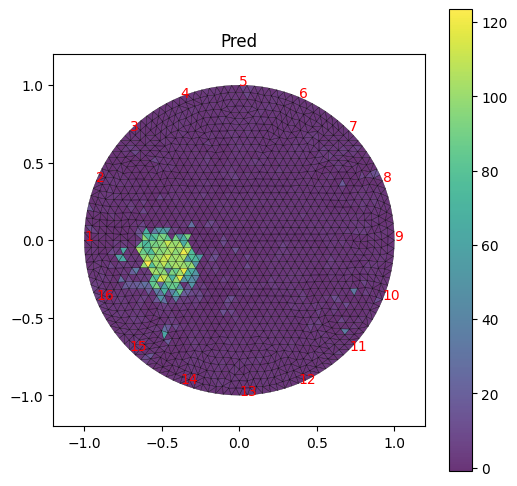

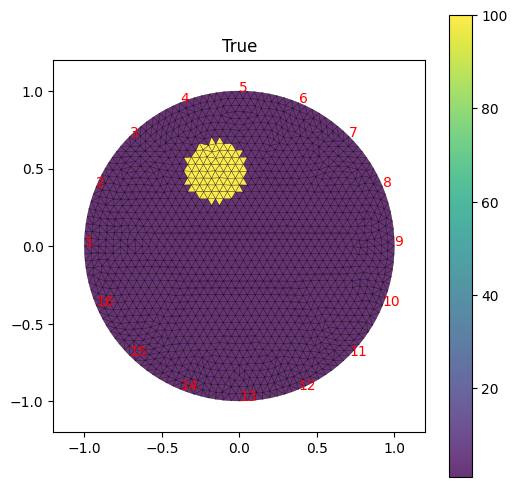

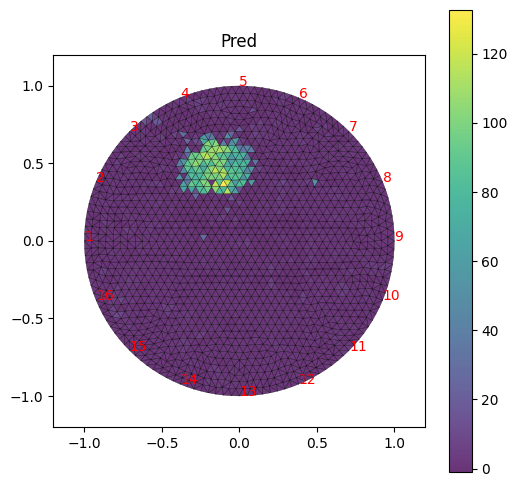

In [12]:
for idx in np.random.randint(0, high=gamma_test.shape[0], size=5):
    plot_mesh_permarray(mesh_obj, gamma_test[idx, :, 0], title="True")
    plot_mesh_permarray(mesh_obj, gamma_hat[idx, :, 0], title="Pred")

